# pH-Absorbance Calibration with PyTorch 

In this notebook, we will be revisiting the data I collected in my UCLA undergrad Bioengineering capstone project. This data involves an absorbance based pH sensor (using an Arduino, LED, and phenol red indicator solution) for noninvasive monitoring of cell culture. By normalizing the voltage reading to that of phosphate buffered saline as blank, we obtained the Absorbance: $A = -\log \frac{I}{I_{PBS}}$. 

The theoretical equation relating pH to absorbance is then given by: 

\begin{equation}

A = f(pH) = \frac{A_{max}}{1 + 10^{pK_{a} - pH}}

\end{equation}

This corresponds to a sigmoid curve from $0$ to $A_{max}$. We choose to add in an extra shape parameter $\phi$ to account for deviations from the theory and use the natura exponential: 

\begin{equation}

A = f(pH) = \frac{A_{max}}{1 + e^{(pK_{a} - pH)/\phi}}

\end{equation}


Unlike say a typical logistic regression sigmoid, this sigmoid has parameters that need to be found via nonlinear least square optimization methods. The loss to be minimized is the mean squared error: 

\begin{equation}

Loss(A_{max},pK_{a},\phi) = \frac{1}{n} \sum^{n}_{i=1} (A_i - \frac{A_{max}}{1 + e^{(pK_{a} - pH_{i})/\phi}})^{2}

\end{equation}



We also have some prior information from theory. It can be shown with algebra that Equation (2) simplifies to Equation (1) when $\phi = \frac{1}{\log(10)} \approx 0.4343$. Additionally the theoretical pKa of phenol red is $pK_{a} = 7.6$. In a frequentist sense, this prior knowledge can be used to add regularization terms. For $A_{max}$ we do not necessarily have prior information, but we do not want the maximum absorbance to be extremely high, and thus can regularize it toward 0. An L1 penalty (in this case it will simplify to absolute values) will be used to regularize these parameters and will penalize the deviation from these prior values: 

\begin{equation}

Penalty(A_{max},pK_{a},\phi) = \lambda_{A_{max}} |A_{max}| + \lambda_{pK_{a}} |pK_{a} - 7.6| + \lambda_{\phi}|\phi - \frac{1}{\log(10)}|

\end{equation}

The minimization problem, with $\theta = (A_{max},pK_{a},\phi)$ then becomes: 

\begin{equation}

\underset{\theta}{\arg\max} (Loss(\theta) + Penalty(\theta))

\end{equation}




## Nonlinear Least Squares and Nonlinear Mixed Model

This dataset consists of 4 Trials, and during the trial, the solution pH was adjusted by adding very small drops of concentrated HCl or NaOH to neglect volume changes. The absorbance was measured and calibrated to a standard pH sensor. However, the nature of the experiment leads to correlated data points within a given trial. **In this first section, we will investigate the dataset with standard built in methods**. 

We will fit NLS models from a wrapper calling R's nls() and (for comparison) scipy least_squares(). These do not account for correlation. To account for correlation, a nonlinear mixed model (NLMM) must be used. This is done through a wrapper that calls R's nlmer() function from lme4 package. 

It is assumed that the only random effect is for $A_{max}$ and is normally distributed: 

\begin{equation}

A_{max,Trial} \sim N(A_{max},\sigma_{A_{max}}^{2})

\end{equation}

The rpy2 package is used to communicate with R in order to use the wrappers found in the pHAbs_NLSNLMM.R file 

All of these are unregularized (beyond the trial-specific regularization toward the mean induced by random effects in the NLMM from nlmer())

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import ggplot, geom_point,geom_line, aes
from scipy.stats import truncnorm
from scipy.optimize import least_squares

In [2]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

In [3]:

base = importr('base')
stats = importr('stats')
lme4 = importr('lme4')
ro.r['source']('pHAbs_NLSNLMM.R')

value,[RTYPES.CLOSXP]
visible,[RTYPES.LGLSXP]


In [4]:
data = pd.read_csv("Full_pHAbsdata.csv")
data.sample(frac=1) #randomize row order for later 

,pH,ALED,Trial
11,7.74,0.313864,1
19,4.08,-0.001617,2
27,6.68,0.055223,2
67,5.36,0.005238,4
39,7.96,0.290464,2
...,...,...,...
41,8.51,0.335765,2
64,11.56,0.461222,3
72,6.67,0.050556,4
89,10.66,0.413847,4


In [5]:
pH_data = data.pH.to_numpy()
ALED_data = data.ALED.to_numpy()

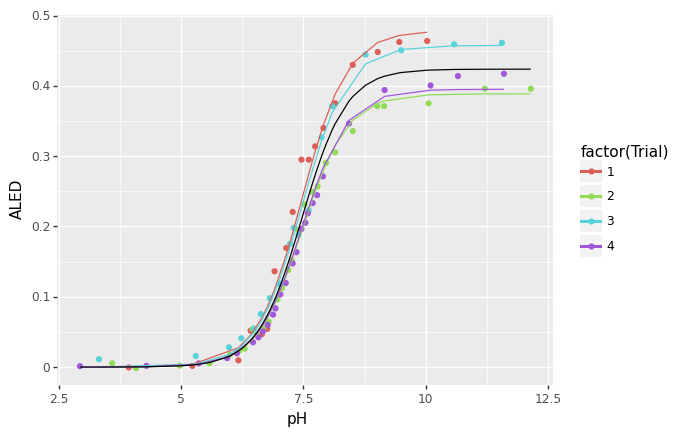

<ggplot: (8763257954582)>

In [6]:

with localconverter(ro.default_converter + pandas2ri.converter):
  NLSresult = ro.r.Fit_NLS(data)
  NLMMresult = ro.r.Fit_NLMM(data)

data["Ahat_NLS"] = np.array(stats.predict(NLSresult))
data["Ahat_NLMM"] = np.array(stats.predict(NLMMresult))

(ggplot(data,aes('pH','ALED',color ='factor(Trial)')) 
+ geom_point() + geom_line(aes('pH','Ahat_NLMM',color='factor(Trial)'))
+ geom_line(aes('pH','Ahat_NLS'),inherit_aes=False))

The data and the fitted values from R's nls() and nlmer() (colored) are seen above. The dark curve represents the overall average relationship based on nls() while the different colored curves are the Trial-specific fits as calculated by nlmer() with a random effect on $A_{max}$. The differences in $A_{max}$ can be caused by differing optics between the trials, which would affect how the light enters the cuvette. 

## Nonlinear Least Squares Results (R nls())

In [7]:
print(base.summary(NLSresult))


Formula: ALED ~ Amax/(1 + exp((pKa - pH)/phi))

Parameters:
     Estimate Std. Error t value Pr(>|t|)    
Amax 0.423757   0.006912   61.30   <2e-16 ***
pKa  7.470071   0.027519  271.45   <2e-16 ***
phi  0.453836   0.023565   19.26   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02612 on 88 degrees of freedom

Number of iterations to convergence: 5 
Achieved convergence tolerance: 2.001e-06




According to R nls(), we find that $\hat{\theta} = (\hat{A_{max}},\hat{pK_{a}},\hat{\phi}) = (0.42,7.47,0.45)$

The pKa is in agreement with the theory, although to assess this rigorously (and trust the SEs) we should use the mixed model approach. Before that, we will try scipy least_squares() next. 

In [8]:

def pHAbsfun(theta,pH,Aobs):
    A = theta[0]/(1+np.exp((theta[1]-pH)/(theta[2])))
    res = A-Aobs
    return res

pHAbsdata_fun = lambda theta: pHAbsfun(theta,pH_data,ALED_data)

ls_result = least_squares(pHAbsdata_fun,[0.5,7.6,0.4])


In [9]:
ls_result.x, ls_result.cost

(array([0.42375714, 7.47007174, 0.45383623]), 0.03002231818680512)

The results between R's nls() and scipy least_squares() are in agreement for the coefficient values. 

## Nonlinear Mixed Effect Model (R nlmer())

In [10]:
print(base.summary(NLMMresult))

Nonlinear mixed model fit by maximum likelihood  ['nlmerMod']
Formula: ALED ~ nfunall(pH, Amax, pKa, phi) ~ Amax | Trial
   Data: data

     AIC      BIC   logLik deviance df.resid 
  -497.3   -484.7    253.7   -507.3       86 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9346 -0.6216 -0.0852  0.5278  4.2925 

Random effects:
 Groups   Name Variance  Std.Dev.
 Trial    Amax 0.0015279 0.03909 
 Residual      0.0001855 0.01362 
Number of obs: 91, groups:  Trial, 4

Fixed effects:
     Estimate Std. Error t value
Amax  0.42990    0.01990   21.60
pKa   7.46974    0.01498  498.76
phi   0.46458    0.01289   36.04

Correlation of Fixed Effects:
    Amax  pKa  
pKa 0.133      
phi 0.092 0.497



Based on the above, we can compute a z-score for $pK_{a}$ and $\phi$ to compare them to 7.6 and 1/log(10) respectively: 

\begin{equation}

|z_{pKa}| = |\frac{7.469-7.6}{0.015}| =  8.69 \\

|z_{\phi}| = |\frac{0.4646 - 0.4343}{0.013}| = 2.33 

\end{equation}

With a bonferroni correction for 2 tests assuming overall familywise error rate of $\alpha = 0.05$, the critical value for each test (per test $\alpha = 0.025$) occurs at $z_{crit} = 2.24$. Thus we reject both null hypotheses, and there is a significant difference obtained in our experiment vs the theoretical curve. However, this difference may not be practically significant, and as long as the results from our device are consistent, that is all that matters for calibrating the sensor. 

Based on the above parameters for the NLMM, we can also simulate more values to obtain a larger dataset for the later parts involving PyTorch: 

## pH-Absorbance Simulation Functions

In [11]:
def generate_pHAbs(n,Amax=0.43,pKa=7.47,phi=0.46,sd_e=0.025):
    mean_pH,sd_pH = 7.6, 2.2
    min_pH, max_pH = 0, 14
    a,b = (min_pH - mean_pH)/sd_pH , (max_pH-mean_pH)/sd_pH
    pH = truncnorm.rvs(a,b,loc=mean_pH,scale=sd_pH,size=n)
    e = np.random.normal(loc=0,scale=sd_e,size=n)
    A = Amax / (1+(np.exp(pKa-pH))/phi) + e
    simdf = pd.DataFrame({'pH': pH,'ALED': A})
    return simdf

def generate_pHAbs_Trials(Trials,n,Amax=0.43,Asd=0.04,pKa=7.47,phi=0.46,sd_e=0.025):
    Amaxes = np.random.normal(Amax,Asd,Trials)
    simdfall = []
    for i in range(Trials):
        simdf = generate_pHAbs(n=n,Amax=Amaxes[i],pKa=pKa,phi=phi,sd_e=sd_e)
        simdf['Trial'] = i+1 
        simdfall.append(simdf)
    simdfall = pd.concat(simdfall)
    return simdfall 


# PyTorch pH-Absorbance Analysis

## pHAbsorbance Custom Layer

Below, we implement a custom layer that contains the 3 parameters and outputs the absorbance values. A random initialization is used as follows for the parameters (we set reasonable values as if we have not seen the above standard analysis): 

\begin{equation}

A_{max} \sim N(1,0.2^{2}) \\ 
pK_{a} \sim N(7.6,0.5^{2}) \\ 
\phi \sim N(0.5,0.1^{2})

\end{equation}

Notice that nn.Parameter() needs to be used on the weights so that PyTorch optimizer later on knows these are the custom parameters of the layer. Additionally, in the pHAbsLayer custom layer we initialize regularizers to 0, and instead choose to configure them when the pHAbsModel containing the layer is instantiated. 

In [12]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


In [13]:
class pHAbsLayer(nn.Module):
    """Custom pHAbs Layer: Amax/(1+e^(pKa-pH)/phi)"""
    def __init__(self):
        super().__init__()
        weights = np.random.normal([1,7.6,0.5],[0.2,0.5,0.1]) #[Amax,pKa,phi]
        weights = torch.from_numpy(weights)
        self.weights = nn.Parameter(weights)
        self.regularizer = torch.zeros(3,dtype=torch.float64)

    def forward(self,x):
        y = self.weights[0]/(1+torch.exp((self.weights[1]-x)/self.weights[2]))
        return y 

## pHAbsModel Model Class 

Now that the pHAbsLayer() custom layer is created, we can use it like any other layer within the actual model class. In this class, we will also leave the option to set hyperparameters. 

In [14]:

class pHAbsModel(nn.Module):
    def __init__(self,lam_Amax=0,lam_pKa=0,lam_phi=0):
        super().__init__()
        self.f_pH = pHAbsLayer()
        self.f_pH.regularizer[0] = lam_Amax
        self.f_pH.regularizer[1] = lam_pKa
        self.f_pH.regularizer[2] = lam_phi 

    def forward(self,x):
        return self.f_pH(x)

## pHAbs Dataset

Below, we create the Dataset class for the data. In this case it is relatively simple, the __getitem__ method should return the features (just pH) and label at a certain index and the __len__ method should return the total length of the dataset. 

In [15]:
class pHAbsDataset(Dataset):
    def __init__(self,pH,Abs):
        self.pH=pH.reshape(-1,1)
        self.Abs = Abs.reshape(-1,1)
    
    def __len__(self):
        return len(self.pH)
    
    def __getitem__(self,idx):
        return self.pH[idx],self.Abs[idx]


## Loss Penalty

As mentioned earlier in this notebook, we will be using an L1 penalty on the parameters' $\theta = (A_{max},pK_{a},\phi)$ deviations from $(0, 7.6, 0.43)$ respectively 

In [16]:
def penalty(model):
    weights = model.f_pH.weights
    regularizer = model.f_pH.regularizer
    prior = torch.Tensor([0,7.6,1/np.log(10)]) 
    penalty = (weights-prior).abs().dot(regularizer)
    return penalty 

## Train and Test Loop 

Below we define the training and testing loop. On the original dataset, we will use the full data to compare results to the first part and then later on will simulate data to compare train/test curves and effect of regularizers, etc. 

In [17]:

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        pen = penalty(model)

        pen_loss = loss + pen
        # Backpropagation
        optimizer.zero_grad()
        pen_loss.backward() 
        #loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        return(loss)


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            

    test_loss /= size
    print(f"Avg loss: {test_loss:>8f} \n")
    return(test_loss)


## Train Model on full original data 

We now train the model on the full original data, and, since this dataset is small, we use a batch size of 91 which is all of the data. 

Additionally, the Adam optimizer with a learning rate of 0.01 is used below, the model is trained for 1000 epochs. No regularization is applied for this first time on the full data. 

For reference, we can extract the mean square error from the R nls() fit, which appears to be 0.00066

In [18]:
residNLS = np.array(stats.residuals(NLSresult))
np.mean(np.square(residNLS))

0.0006598311689431394

In [19]:
origdataset = pHAbsDataset(pH_data,ALED_data)

origdataloader = DataLoader(origdataset,batch_size=91,shuffle=True)

In [20]:

origmodel = pHAbsModel()
learning_rate = 0.01

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(origmodel.parameters(), lr=learning_rate)


In [21]:
%%capture 

epochs = 1000
loss_orig = np.zeros(epochs)
Amax_orig = np.zeros(epochs)
pKa_orig = np.zeros(epochs)
phi_orig = np.zeros(epochs)

for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    loss_orig[i] = train_loop(origdataloader, origmodel, loss_fn, optimizer)
    Amax_orig[i] = origmodel.f_pH.weights[0]
    pKa_orig[i] = origmodel.f_pH.weights[1]
    phi_orig[i] = origmodel.f_pH.weights[2]


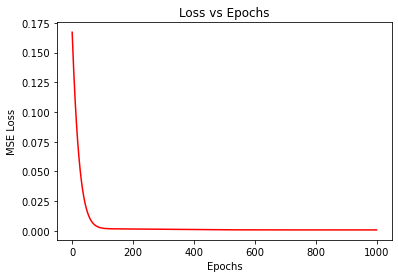

In [22]:
plt.plot(loss_orig,"r-")
plt.title("Loss vs Epochs")
plt.ylabel("MSE Loss")
plt.xlabel("Epochs")
plt.show()

In [23]:
loss_orig[-1]

0.0006598443647888356

The above final loss is the same as the loss obtained for R's nls() function on this dataset. The parameter weights are also almost exactly the same as obtained via nls(), and thus solving the NLS problem via PyTorch tools was a success. Below we can examine the parameter traces vs epochs as well:  

In [24]:
origmodel.f_pH.weights

Parameter containing:
tensor([0.4240, 7.4712, 0.4544], dtype=torch.float64, requires_grad=True)

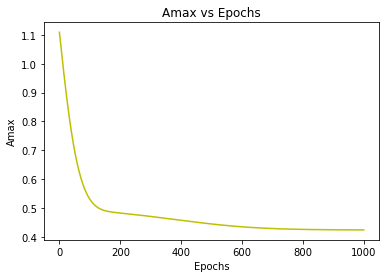

In [25]:
plt.plot(Amax_orig,"y-")
plt.title("Amax vs Epochs")
plt.ylabel("Amax")
plt.xlabel("Epochs")
plt.show()

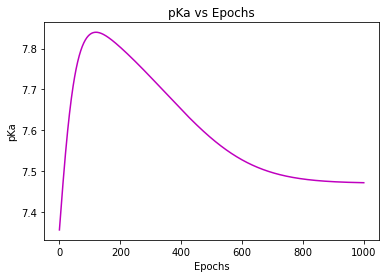

In [26]:
plt.plot(pKa_orig,"m-")
plt.title("pKa vs Epochs")
plt.ylabel("pKa")
plt.xlabel("Epochs")
plt.show()

The pKa trace is interesting in that at first it started at a high value 8.4 and increased for some time until 7.85 before it started decreasing. 

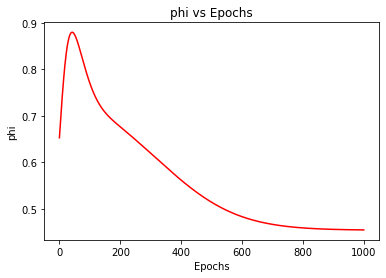

In [27]:
plt.plot(phi_orig,"r-")
plt.title("phi vs Epochs")
plt.ylabel("phi")
plt.xlabel("Epochs")
plt.show()

The trace for the $\phi$ parameter shows an peak as well, although shorter indicating that at first this parameter was increasing briefly before it settled on the final value. This whole time, the loss was still decreasing, however. 

## Experiment with regularization on original data 

Below, we experiment with some regularization on the original data. The regularization parameters are $\lambda = (0.0001,0.001,0.01)$ for $(A_{max},pK_{a},\phi)$ respectively



In [28]:
%%capture 

origmodelreg = pHAbsModel(lam_Amax=0.0001,lam_pKa=0.001,lam_phi=0.01)
learning_rate = 0.01

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(origmodelreg.parameters(), lr=learning_rate)

epochs = 1000
loss_origreg = np.zeros(epochs)

for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    loss_origreg[i] = train_loop(origdataloader, origmodelreg, loss_fn, optimizer)


In [29]:
print(loss_origreg[-1])
origmodelreg.f_pH.weights

0.0006840412471735585


Parameter containing:
tensor([0.4267, 7.4964, 0.4337], dtype=torch.float64, requires_grad=True)

As seen above, the parameters are closer to the prior values that were mentioned in the beginning of this notebook. Thus the regularization has worked.

We now move on to simulated data where we can also investigate the train-val curves to investigate phenomenon such as early stopping. 

## Simulated Data 

Below, we simulate 100 Trials with 100 points each for both a Training and Validation set. The true parameters in the training set are set to $A_{max,true} = 0.43,~~ pK_{a,true} = 7.47,~~ \phi_{true} =  0.46$. 

To examine how distribution shift may affect the training/val curves, the true parameters in the validation set are set to $A_{max,true} = 0.40,~~ pK_{a,true} = 7.52,~~ \phi_{true} =  0.48$. 

The noise in the absorbance value is $\epsilon \sim N(0, 0.025^{2})$

In [30]:

np.random.seed(100)
TrainSim = generate_pHAbs_Trials(Trials=100,n=100)
np.random.seed(10)
ValSim = generate_pHAbs_Trials(Trials=100,n=100,Amax=0.40,pKa=7.52,phi=0.48)


In [31]:
pH_Train, Abs_Train = TrainSim.pH.to_numpy(), TrainSim.ALED.to_numpy()
pH_Val,Abs_Val = ValSim.pH.to_numpy(), ValSim.ALED.to_numpy()

In [32]:
TrainDS = pHAbsDataset(pH_Train,Abs_Train)
ValDS = pHAbsDataset(pH_Val,Abs_Val)

TrainLoader = DataLoader(TrainDS,batch_size=100,shuffle=True)
ValLoader = DataLoader(ValDS,batch_size=100,shuffle=True)

In [33]:
%%capture 

sim_model = pHAbsModel()
learning_rate = 0.01

loss_fn_train = nn.MSELoss()
loss_fn_val = nn.MSELoss(reduction="sum") #because test loop divides in the end

optimizer = torch.optim.Adam(sim_model.parameters(), lr=learning_rate)

epochs = 1000
loss_simtrain = np.zeros(epochs)
loss_simval = np.zeros(epochs)

for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    loss_simtrain[i] = train_loop(TrainLoader, sim_model, loss_fn_train, optimizer)
    loss_simval[i] = test_loop(ValLoader,sim_model,loss_fn_val)

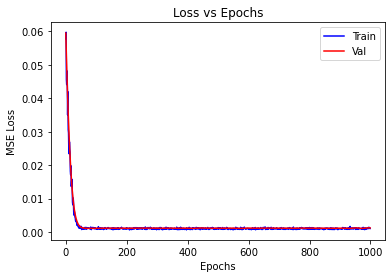

In [34]:
plt.plot(loss_simtrain,"b-")
plt.plot(loss_simval,"r-")
plt.legend(["Train","Val"])
plt.title("Loss vs Epochs")
plt.ylabel("MSE Loss")
plt.xlabel("Epochs")
plt.show()

In [35]:
sim_model.f_pH.weights

Parameter containing:
tensor([0.4332, 8.2639, 0.9997], dtype=torch.float64, requires_grad=True)

In [36]:
final_losstrain = loss_simtrain[-1]
final_lossval = loss_simval[-1]

print(f"The final training Loss is: {final_losstrain:.5f} and final validation Loss is: {final_lossval:.5f}")

The final training Loss is: 0.00108 and final validation Loss is: 0.00124


This time, the $pK_{a} = 8.27,~~\phi = 1.01$ which are far from the true parameter values. We can check the answer with the wrapper from R's nls(), which confirms that this is just a result of the data obtained. The good news is that the validation loss and training loss are still about the same. The slight distribution shift did not appear to affect the results too much in this case. 

In [37]:
with localconverter(ro.default_converter + pandas2ri.converter):
  NLSTrainresult = ro.r.Fit_NLS(TrainSim)

print(base.summary(NLSTrainresult))



Formula: ALED ~ Amax/(1 + exp((pKa - pH)/phi))

Parameters:
     Estimate Std. Error t value Pr(>|t|)    
Amax 0.427711   0.001322   323.6   <2e-16 ***
pKa  8.255887   0.009396   878.6   <2e-16 ***
phi  1.002325   0.006636   151.1   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0322 on 9997 degrees of freedom

Number of iterations to convergence: 6 
Achieved convergence tolerance: 8.089e-08




## With Regularization 

Now we will try the same thing as above with regularization and determine whether this ends up having a better test error. The same regularization parameters as earlier will be used. Ideally, cross validation or other hyperparameter selection methods would be used. 

In [41]:
%%capture 

sim_modelreg = pHAbsModel(lam_Amax=0.0001,lam_pKa=0.001,lam_phi=0.01)
learning_rate = 0.01

loss_fn_train = nn.MSELoss()
loss_fn_val = nn.MSELoss(reduction="sum") #because test loop divides in the end

optimizer = torch.optim.Adam(sim_modelreg.parameters(), lr=learning_rate)

epochs = 1000
loss_simtrain = np.zeros(epochs)
loss_simval = np.zeros(epochs)

for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    loss_simtrain[i] = train_loop(TrainLoader, sim_modelreg, loss_fn_train, optimizer)
    loss_simval[i] = test_loop(ValLoader,sim_modelreg,loss_fn_val)

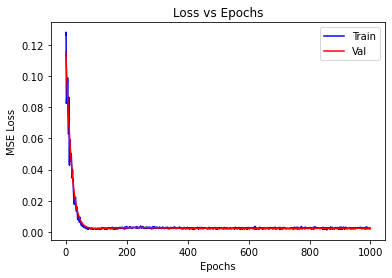

In [42]:
plt.plot(loss_simtrain,"b-")
plt.plot(loss_simval,"r-")
plt.legend(["Train","Val"])
plt.title("Loss vs Epochs")
plt.ylabel("MSE Loss")
plt.xlabel("Epochs")
plt.show()

In [43]:
final_losstrain = loss_simtrain[-1]
final_lossval = loss_simval[-1]

print(f"The final training Loss is: {final_losstrain:.5f} and final validation Loss is: {final_lossval:.5f}")

The final training Loss is: 0.00233 and final validation Loss is: 0.00237


In this case, the regularization resulted in both worse training and test error, this indicates we are over-regularizing the parameters. In the next run, the regularizers will be decreased 

In [53]:
%%capture

sim_modelreg = pHAbsModel(lam_Amax=1e-5,lam_pKa=1e-5,lam_phi=1e-3)
learning_rate = 0.01

loss_fn_train = nn.MSELoss()
loss_fn_val = nn.MSELoss(reduction="sum") #because test loop divides in the end

optimizer = torch.optim.Adam(sim_modelreg.parameters(), lr=learning_rate)

epochs = 1000
loss_simtrain = np.zeros(epochs)
loss_simval = np.zeros(epochs)

for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    loss_simtrain[i] = train_loop(TrainLoader, sim_modelreg, loss_fn_train, optimizer)
    loss_simval[i] = test_loop(ValLoader,sim_modelreg,loss_fn_val)

In [54]:
final_losstrain = loss_simtrain[-1]
final_lossval = loss_simval[-1]

print(f"The final training Loss is: {final_losstrain:.5f} and final validation Loss is: {final_lossval:.5f}")

The final training Loss is: 0.00112 and final validation Loss is: 0.00124


With a new less conservative choice of hyperparameters after experimenting, the training loss is higher as expected, and the validation loss is ever so slightly lower. 